**Import Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import functools
import random
import math

np.random.seed(2024)

Set up a 10-armed Bandit Testbed (reference: Reinforcement Learning, Sutton Barto Section 2.3). The average reward from each arm is sampled from ~N(0,1)

In [2]:
arms = 10
mean = 0
var = 1
arm_nums = np.arange(arms)
q_star_a = np.zeros(arms)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Explore 4 different exploration algorithms
1.   ε-greedy exploration
2.   optimistic initialization
3.   UCB exploration
4.   Boltzmann exploration



In [3]:
def get_action_value(arms=10, mean=0.0, var=1.0):
    q_star_a = np.random.normal(mean, var, arms)
    return q_star_a

def get_action(est, epsilon, c, action_counts, timestep, temperature):
    p = random.uniform(0,1)
    action = 0
    # apply Boltzmann
    if temperature > 0:
        H = np.zeros(arms)
        for i in range(arms):
            H[i] = est[i] * temperature
        action_probs = np.exp(H) / np.sum(np.exp(H))
        assert(np.isclose(1, np.sum(action_probs)))
        # sample from this distribution
        action = np.random.choice(arms, p=action_probs)
        return action, action_probs

    # apply UCB
    if c > 0:
        est_new = np.zeros(arms)
        for i in range(arms):
            if action_counts[i] == 0:
                est_new[i] = np.inf
            else:
                # count the timestep starting at 1
                est_new[i] = est[i] + c * math.sqrt(np.log(timestep+1) / action_counts[i])
        est = est_new

    # apply epsilon-greedy
    if p < epsilon:
        action = random.randint(0,9)
    else:
        # max_val = np.max(est)
        # max_actions = np.where(est== max_val)[0]
        # action = np.random.choice(max_actions)
        action = np.argmax(est)
    return action

In [4]:
def act(timesteps, epsilon=0, optimistic=0, ucb=0, boltzmann=0):
    q_star_a = get_action_value()
    action_counts = np.zeros(arms)
    reward_sum = np.zeros(arms)
    # initializing values
    val = np.full(arms, optimistic, dtype=float)
    e_reward = np.zeros(timesteps)
    for i in range(timesteps):
        if boltzmann == 0:
            action = get_action(val, epsilon, ucb, action_counts, i, boltzmann)
            exp_reward = (1 - epsilon) * q_star_a[action] + epsilon * np.mean(q_star_a)
        else:
            action, action_probs = get_action(val, epsilon, ucb, action_counts, i, boltzmann)
            exp_reward = 0
            for k in range(arms):
                exp_reward += q_star_a[k] * action_probs[k]

        rewards_t = np.zeros(arms)
        for k in range(arms):
            rewards_t[k] = np.random.normal(q_star_a[k], 1)
        current_reward = rewards_t[action]
        action_counts[action] += 1
        reward_sum[action] += current_reward
        # update rule
        val[action] += (current_reward - val[action]) / action_counts[action]
        assert(np.isclose(val[action], reward_sum[action]/action_counts[action]))

        e_reward[i] = exp_reward
    return e_reward

In [5]:
def av_val(num_experiments = 2000, timesteps=1000, epsilon=0, optimistic=0, ucb=0, boltzmann=0):
    exp_reward = np.zeros((timesteps, num_experiments))
    for i in range(num_experiments):
        exp_reward[:, i] = act(timesteps, epsilon, optimistic, ucb, boltzmann)
    return np.mean(exp_reward, axis=1)

Get the best performance hyperparameters for each explorations

In [6]:
best_hyperparameters = np.zeros((1000,4))
strategies = []

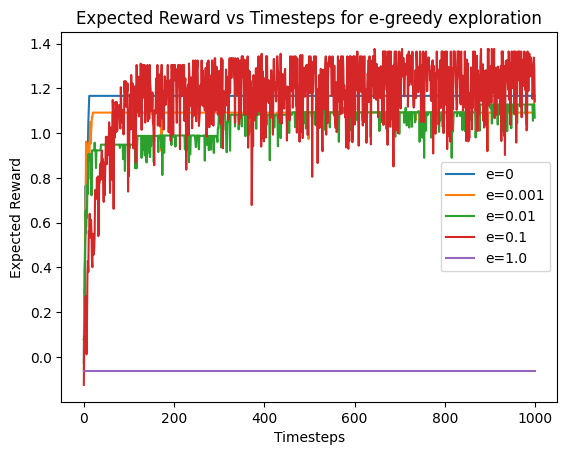

In [7]:
# e-greedy
e_vals = [0, 0.001, 0.01, 0.1, 1.0]
exp_reward = np.zeros((1000, len(e_vals)))
for i in range(len(e_vals)):
    exp_reward[:,i] = av_val(num_experiments=20, epsilon=e_vals[i])

hyperparameters = ["e=0", "e=0.001", "e=0.01", "e=0.1", "e=1.0"]
plt.plot(exp_reward)
plt.ylabel('Expected Reward')
plt.xlabel('Timesteps')
plt.legend(hyperparameters)
plt.title('Expected Reward vs Timesteps for e-greedy exploration')
plt.show()

best = np.argmax(exp_reward[999])
best_hyperparameters[:,0] = exp_reward[:,best]
strategies.append('e-greedy: '+ hyperparameters[best])

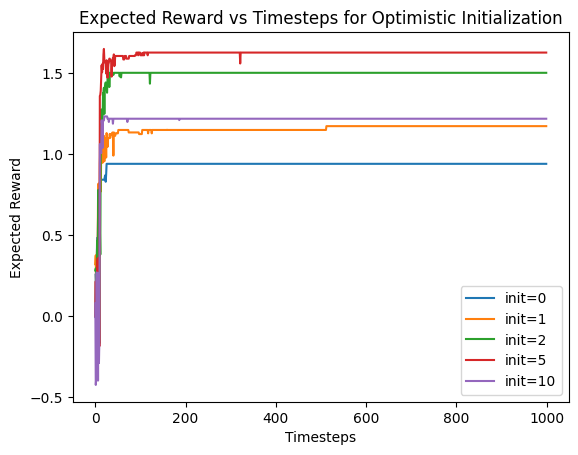

In [8]:
# Optimistic Initialization
start_values = [0, 1, 2, 5, 10]
exp_reward = np.zeros((1000, len(start_values)))
for i in range(len(start_values)):
    exp_reward[:,i] = av_val(num_experiments=20, optimistic=start_values[i])

hyperparameters = ["init=0", "init=1", "init=2", "init=5", "init=10"]
plt.plot(exp_reward)
plt.ylabel('Expected Reward')
plt.xlabel('Timesteps')
plt.legend(hyperparameters)
plt.title('Expected Reward vs Timesteps for Optimistic Initialization')
plt.show()

best = np.argmax(exp_reward[999])
best_hyperparameters[:,1] = exp_reward[:,best]
strategies.append('Optimistic Init: '+ hyperparameters[best])

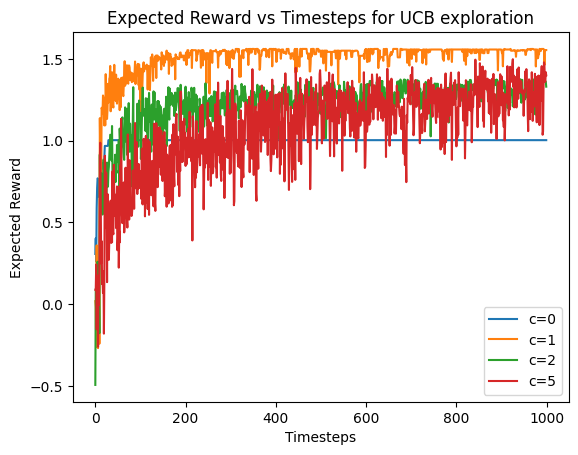

Strategies with best hyperparameters:  ['e-greedy: e=0', 'Optimistic Init: init=5', 'UCB exploration: c=1']


In [9]:
# UCB
c_values = [0, 1, 2, 5]
exp_reward = np.zeros((1000, len(c_values)))
for i in range(len(c_values)):
    exp_reward[:,i] = av_val(num_experiments=20, ucb=c_values[i])

hyperparameters = ["c=0", "c=1", "c=2", "c=5"]
plt.plot(exp_reward)
plt.ylabel('Expected Reward')
plt.xlabel('Timesteps')
plt.legend(hyperparameters)
plt.title('Expected Reward vs Timesteps for UCB exploration')
plt.show()
best = np.argmax(exp_reward[999])
best_hyperparameters[:,2] = exp_reward[:,best]

strategies.append('UCB exploration: '+ hyperparameters[best])
print("Strategies with best hyperparameters: ", strategies)

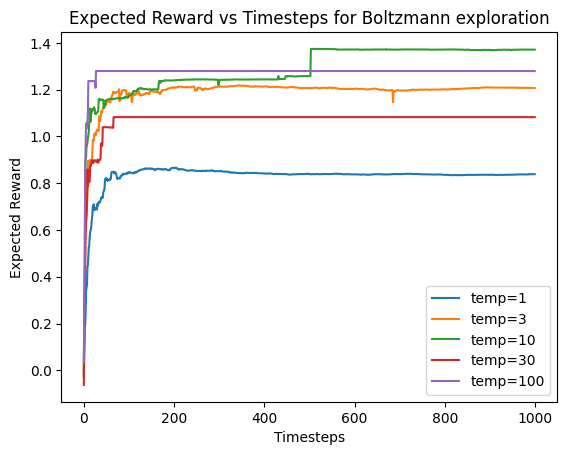

Strategies with best hyperparameters:  ['e-greedy: e=0', 'Optimistic Init: init=5', 'UCB exploration: c=1', 'Boltzmann: temp=10']


In [10]:
# Boltzmann exploration
boltzmann_values = [1, 3, 10, 30, 100]
exp_reward = np.zeros((1000, len(boltzmann_values)))
for i in range(len(boltzmann_values)):
    exp_reward[:,i] = av_val(num_experiments=20, boltzmann=boltzmann_values[i])

hyperparameters = ["temp=1", "temp=3", "temp=10", "temp=30", "temp=100"]
plt.plot(exp_reward)
plt.ylabel('Expected Reward')
plt.xlabel('Timesteps')
plt.legend(hyperparameters)
plt.title('Expected Reward vs Timesteps for Boltzmann exploration')
plt.show()

best = np.argmax(exp_reward[999])
best_hyperparameters[:,3] = exp_reward[:,best]
strategies.append('Boltzmann: '+ hyperparameters[best])
print("Strategies with best hyperparameters: ", strategies)

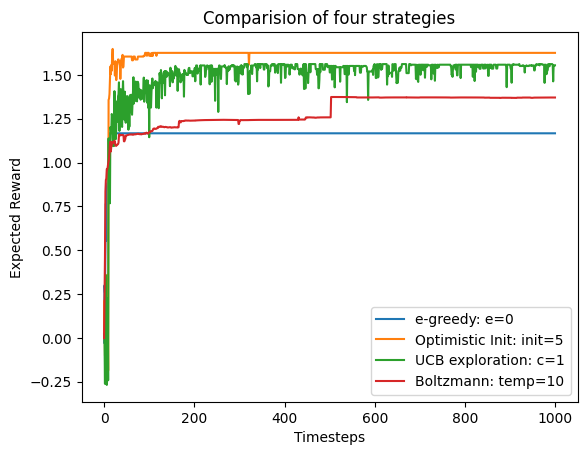

In [11]:
# Comparison across 4 strategies
# strategies = ['e-greedy', 'Optimistic Init', 'UCB', 'Boltzmann']
plt.plot(best_hyperparameters)
plt.ylabel('Expected Reward')
plt.xlabel('Timesteps')
plt.legend(strategies)
plt.title('Comparision of four strategies')
plt.show()
